In [2]:
# Download and minimally validate daily price data

## Principles
#- Save raw data as-is (write once) for reproducibility.
#- Use adjusted close for total-return series (dividends/splits).
#- Keep transformations explicit and version-controlled.

In [4]:
!pip install yfinance

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 42.7 MB/s eta 0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15636 sha256=9e7e55e5b17799af32fe911b73687d1d1aeaff0d21d6c829dbe2f8bd1710f969
  Stored in directory: /home/dermot.kelly/.cache/pip/wheels/e9/25/85/25d2e1cfc0ece64b930b16972f7e4cc3599c43b531f1eba06d
Successfully built multitasking


In [5]:
from pathlib import Path
import pandas as pd
import yfinance as yf

So the next cell sets the instrument (SPY) and the date range
SPY is a fund that tracks the S&P 500, we have asked for data since 1993
Creates the output folder (if it doesnt exits)
Defines where CSV will be saved

In [6]:
TICKER = "SPY"
START = "1993-01-01"
END = None  # None = latest available

OUTDIR_RAW = Path("../data/raw")
OUTDIR_RAW.mkdir(parents=True, exist_ok=True)

OUTPATH = OUTDIR_RAW / f"{TICKER}_daily.csv"
OUTPATH

PosixPath('../data/raw/SPY_daily.csv')

So we are now downloading a table of prices over time. START and END have already been defined above. Interval 1d means daily data, so each row is one trading day. Autoadjust=False means data is not adjusted for dividends and splits etc. actions = False means dividends and splits are not included as seperate rows (Adj Close)already incorporates their effect).

In [7]:
df = yf.download(
    TICKER,
    start=START,
    end=END,
    auto_adjust=False,   # keep 'Adj Close' explicitly
    progress=False,
    actions=False,
    interval="1d",
)

if df.empty:
    raise ValueError(f"No data returned for ticker={TICKER}")

df.head()


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY,SPY
Date,,,,,,
1993-01-29,24.241404,43.93750,43.96875,43.75000,43.96875,1003200
1993-02-01,24.413826,44.25000,44.25000,43.96875,43.96875,480500
1993-02-02,24.465551,44.34375,44.37500,44.12500,44.21875,201300
1993-02-03,24.724171,44.81250,44.84375,44.37500,44.40625,529400
1993-02-04,24.827604,45.00000,45.09375,44.46875,44.96875,531500


In [9]:
df = df.copy()
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

# --- Flatten yfinance MultiIndex columns if present ---
# Common cases:
# 1) MultiIndex like ('Adj Close', 'SPY') or ('Price', 'Adj Close', 'SPY') depending on version/output
if isinstance(df.columns, pd.MultiIndex):
    # Try to keep the "field" level (Open/High/Low/Close/Adj Close/Volume)
    # Often it's the last-but-one level or the first level; this handles both by searching.
    levels = df.columns.names

    # Heuristic: find the level that contains the field names
    field_names = {"Open", "High", "Low", "Close", "Adj Close", "Volume"}
    field_level = None
    for i in range(df.columns.nlevels):
        vals = set(df.columns.get_level_values(i))
        if field_names.issubset(vals):
            field_level = i
            break

    if field_level is None:
        # Fallback: collapse to strings
        df.columns = [" ".join([str(x) for x in tup if x is not None]).strip() for tup in df.columns]
    else:
        df.columns = df.columns.get_level_values(field_level)

# Ensure columns are plain strings
df.columns = [str(c) for c in df.columns]

required_cols = {"Open", "High", "Low", "Close", "Adj Close", "Volume"}
missing = required_cols.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns after flattening: {missing}")

# Remove duplicated dates (rare but good hygiene)
df = df[~df.index.duplicated(keep="first")]

# Ensure numeric
for col in ["Open", "High", "Low", "Close", "Adj Close", "Volume"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["Adj Close", "Volume"])

print(f"Rows: {len(df):,}")
print(f"Date range: {df.index.min().date()} -> {df.index.max().date()}")
print("Columns:", list(df.columns))


Rows: 8,310
Date range: 1993-01-29 -> 2026-02-03
Columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']


In [10]:
OUTPATH = Path("../data/raw") / "SPY_daily.csv"
df.to_csv(OUTPATH)
print("Saved:", OUTPATH)

Saved: ../data/raw/SPY_daily.csv


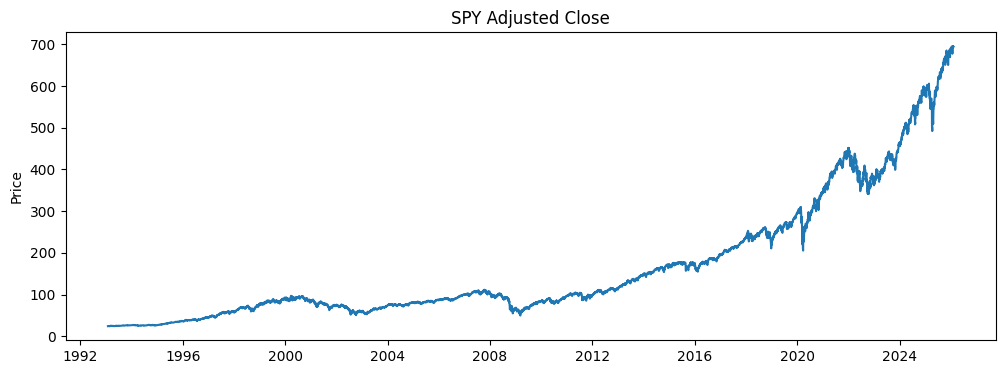

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df.index, df["Adj Close"])
plt.title(f"{TICKER} Adjusted Close")
plt.ylabel("Price")
plt.show()